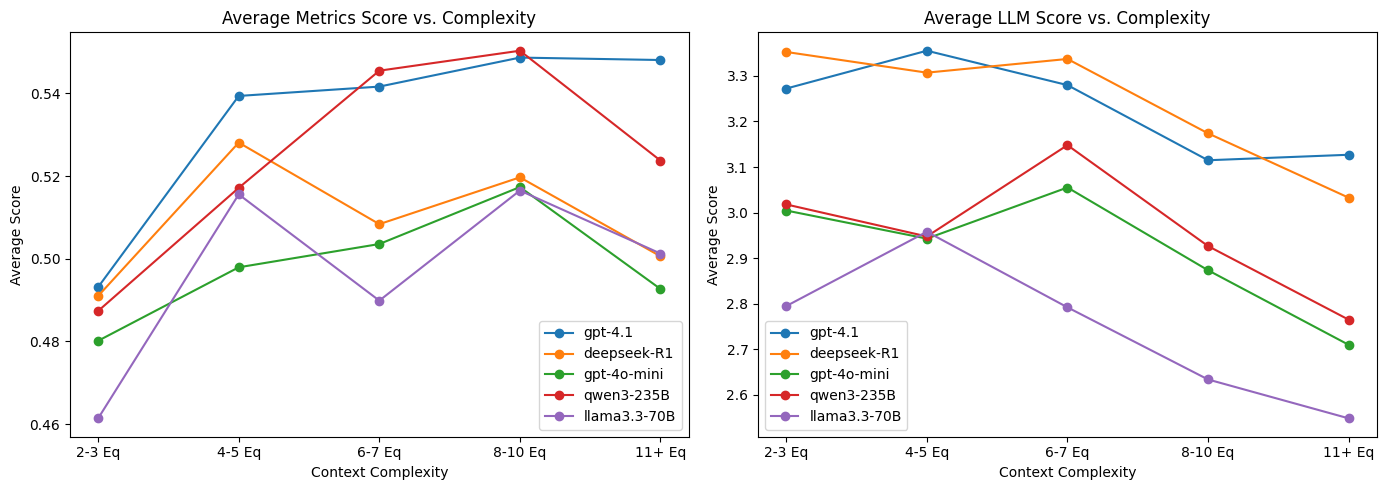

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

results_folder = "D:/0_Master_Thesis/math_agent/Evaluation/data/result_csv"

def categorize_complexity(n_eq):
    if 2 <= n_eq <= 5:
        return "2-5 Eq"
    elif 6 <= n_eq <= 10:
        return "6-10 Eq"
    else:
        return "11+ Eq"


def extract_model_name(filename):
    match = re.match(r"(.*?)_results_evaluation_table", filename)
    return match.group(1) if match else None

summary_tables = {}
agg_results = []

metric_cols = ["texbleu",  "rouge_l", "levenshtein_distance", "sequence_similarity" ] 
llm_cols = ["semantic_score", "reasoning_score" ]# metric_cols = ["texbleu",  "rouge_l", "levenshtein_distance", "sequence_similarity" ] 


files = os.listdir(results_folder)
models = set(extract_model_name(f) for f in files if extract_model_name(f))
models = [m for m in models if m is not None]

for model_name in models:
    metric_file = f"{model_name}_results_evaluation_table_metrics.csv"
    llm_file = f"{model_name}_results_evaluation_table_llm_judge_results.csv"

    metric_path = os.path.join(results_folder, metric_file)
    llm_path = os.path.join(results_folder, llm_file)

    if not (os.path.exists(metric_path) and os.path.exists(llm_path)):
        continue

    # Load data
    metrics_df = pd.read_csv(metric_path)
    llm_df = pd.read_csv(llm_path)

    # Equation counts
    eq_counts = metrics_df.groupby("paper_id")["equation_id"].nunique().reset_index()
    eq_counts.rename(columns={"equation_id": "n_eq"}, inplace=True)

    # Merge and add complexity group
    metrics_df = metrics_df.merge(eq_counts, on="paper_id")
    llm_df = llm_df.merge(eq_counts, on="paper_id")
    metrics_df["complexity_group"] = metrics_df["n_eq"].apply(categorize_complexity)
    llm_df["complexity_group"] = llm_df["n_eq"].apply(categorize_complexity)

    # Group means
    metric_group = metrics_df.groupby("complexity_group")[metric_cols].mean().reset_index()
    llm_group = llm_df.groupby("complexity_group")[llm_cols].mean().reset_index()

    # Compute aggregate score = mean of metrics (optional: normalize beforehand if scales differ significantly)
    for _, row in metric_group.iterrows():
        agg_score = row[metric_cols].mean()
        agg_results.append({"model": model_name, "complexity": row["complexity_group"], "type": "Metrics", "score": agg_score})
    for _, row in llm_group.iterrows():
        agg_score = row[llm_cols].mean()
        agg_results.append({"model": model_name, "complexity": row["complexity_group"], "type": "LLM", "score": agg_score})

# Convert to df for plotting
agg_df = pd.DataFrame(agg_results)
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, eval_type in zip(axes, ["Metrics", "LLM"]):
    for model in agg_df["model"].unique():
        subset = agg_df[(agg_df["model"] == model) & (agg_df["type"] == eval_type)]
        subset = subset.set_index("complexity").reindex(["2-5 Eq", "6-10 Eq", "11+ Eq"])  # Ensure order

        ax.plot(subset.index, subset["score"], marker='o', label=model)
    ax.set_title(f"Average {eval_type} Score vs. Complexity")
    ax.set_xlabel("Context Complexity")
    ax.set_ylabel("Average Score")
    ax.legend()

plt.tight_layout()
plt.show()


